In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller

# 1. Data Collection

In [2]:
def display_tickers(tickers):
    print("\nNifty 50 Company Ticker Symbols (Yahoo Finance Format):")
    print(*tickers, sep=", ")  

In [3]:
tickers_df = pd.read_csv("nifty50_tickers.csv")
tickers = tickers_df['Ticker'].tolist()
display_tickers(tickers)


Nifty 50 Company Ticker Symbols (Yahoo Finance Format):
ADANIENT.NS, ADANIPORTS.NS, APOLLOHOSP.NS, ASIANPAINT.NS, AXISBANK.NS, BAJAJ-AUTO.NS, BAJFINANCE.NS, BAJAJFINSV.NS, BEL.NS, BPCL.NS, BHARTIARTL.NS, BRITANNIA.NS, CIPLA.NS, COALINDIA.NS, DRREDDY.NS, EICHERMOT.NS, GRASIM.NS, HCLTECH.NS, HDFCBANK.NS, HDFCLIFE.NS, HEROMOTOCO.NS, HINDALCO.NS, HINDUNILVR.NS, ICICIBANK.NS, INDUSINDBK.NS, INFY.NS, ITC.NS, JSWSTEEL.NS, KOTAKBANK.NS, LT.NS, M&M.NS, MARUTI.NS, NESTLEIND.NS, NTPC.NS, ONGC.NS, POWERGRID.NS, RELIANCE.NS, SBILIFE.NS, SHRIRAMFIN.NS, SBIN.NS, SUNPHARMA.NS, TCS.NS, TATACONSUM.NS, TATAMOTORS.NS, TATASTEEL.NS, TECHM.NS, TITAN.NS, TRENT.NS, ULTRACEMCO.NS, WIPRO.NS


In [4]:

# Ask user for a company
user_input = input("\nPlease enter the name of the company you want to download data for: ").strip()

# Find the corresponding ticker (assumed tickers_df is already defined)
matched_ticker = None
for ticker in tickers_df['Ticker']:
    if ticker.split('.')[0].lower() == user_input.lower():
        matched_ticker = ticker
        break

# Download the data if ticker is found
if matched_ticker:
    folder = 'CSVfiles'  # Ensure the folder name is defined
    try:
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        # Get yesterday's date
        yesterday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
        
        # Download the stock data from 2017 to yesterday's date
        data = yf.download(matched_ticker, start='2017-01-01', end=yesterday)
        data.fillna(0, inplace=True)
        data
        
        # Save to CSV
        filename = os.path.join(folder, f"{matched_ticker}.csv")
        data.to_csv(filename)
        print(f"\nData for {matched_ticker} saved to {filename}")

    except Exception as e:
        print(f"An error occurred while downloading data for {matched_ticker}: {e}")

else:
    print("Company not found in Nifty 50 list.")


[*********************100%***********************]  1 of 1 completed


Data for ICICIBANK.NS saved to CSVfiles\ICICIBANK.NS.csv


In [5]:
yesterday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')

stock_data = yf.download(f'{user_input}.NS', start='2017-01-01', end=yesterday)
stock_data.fillna(0, inplace=True)
df = pd.DataFrame(stock_data)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,233.000000,233.000000,225.545456,229.045456,216.413559,10404350
2017-01-03,229.181824,232.181824,226.636368,231.272720,218.517990,10236706
2017-01-04,231.136368,232.500000,227.636368,228.272720,215.683426,6901181
2017-01-05,230.181824,235.000000,229.272720,233.863632,220.966003,13830668
2017-01-06,234.772720,237.636368,233.818176,234.681824,221.739059,9055143
...,...,...,...,...,...,...
2024-11-04,1290.099976,1291.800049,1270.050049,1277.199951,1277.199951,14309121
2024-11-05,1273.000000,1301.300049,1263.099976,1296.699951,1296.699951,16431920
2024-11-06,1300.250000,1315.000000,1292.699951,1302.349976,1302.349976,12037405


# 2. Data Preprocessing

<AxesSubplot: xlabel='Date'>

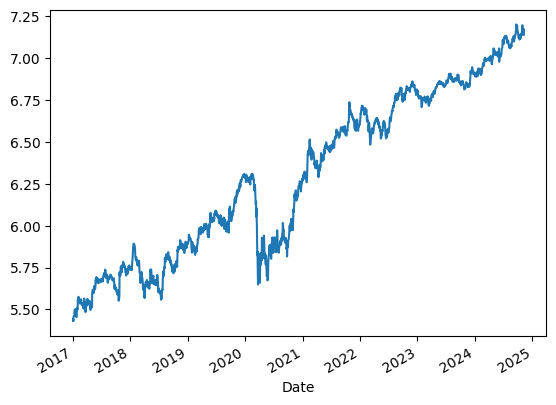

In [6]:
# This applies the natural logarithm (logarithm with base e) to the Close column of the DataFrame df.
# The reason for taking the logarithm of the closing prices is to stabilize the variance,
#  which can help in time series modeling (especially when working with non-stationary data). 
# Log transformations can reduce the effect of large fluctuations and make the data more stationary.


y = np.log(df["Close"])
y.plot()

In [7]:
y.asfreq("D")[:15] 

Date
2017-01-02    5.433920
2017-01-03    5.443598
2017-01-04    5.430541
2017-01-05    5.454738
2017-01-06    5.458231
2017-01-07         NaN
2017-01-08         NaN
2017-01-09    5.460359
2017-01-10    5.466140
2017-01-11    5.483287
2017-01-12    5.496982
2017-01-13    5.495863
2017-01-14         NaN
2017-01-15         NaN
2017-01-16    5.500516
Freq: D, Name: Close, dtype: float64

Let's impute the missing data by forward fill using asfreq method.

In [8]:
y.asfreq("D", method="ffill")[:15]   # used to forward fill missing values.

Date
2017-01-02    5.433920
2017-01-03    5.443598
2017-01-04    5.430541
2017-01-05    5.454738
2017-01-06    5.458231
2017-01-07    5.458231
2017-01-08    5.458231
2017-01-09    5.460359
2017-01-10    5.466140
2017-01-11    5.483287
2017-01-12    5.496982
2017-01-13    5.495863
2017-01-14    5.495863
2017-01-15    5.495863
2017-01-16    5.500516
Freq: D, Name: Close, dtype: float64

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05,
we can say that there is not sufficient proof that the time series is stationary. 
Loosely speaking, it is non-stationary. We need further transformation to make data stationary.
Populary method for making data stationary will be to take "difference". 
Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. 
So we conclude, diff 1 will made the data stationary. 

In [9]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(prices):
    result=adfuller(prices)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(df['Close'])

ADF Test Statistic : 0.25177330303902035
p-value : 0.9750204060087524
#Lags Used : 5
Number of Observations Used : 1935
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
result = adfuller(y.diff(periods=1).dropna())

In [11]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -17.985891
p-value: 0.000000


<AxesSubplot: xlabel='Date'>

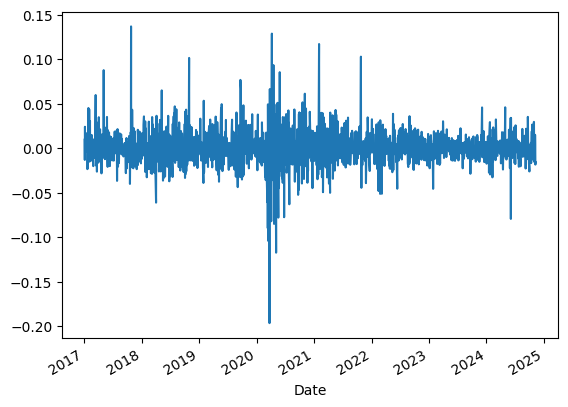

In [12]:
y.diff(periods=1).plot()

In [13]:
y

Date
2017-01-02    5.433920
2017-01-03    5.443598
2017-01-04    5.430541
2017-01-05    5.454738
2017-01-06    5.458231
                ...   
2024-11-04    7.152425
2024-11-05    7.167578
2024-11-06    7.171926
2024-11-07    7.153599
2024-11-08    7.137954
Name: Close, Length: 1941, dtype: float64

In [14]:
y = y.dropna()

# 3. Finding the p,d,q

Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF. p,d,q

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
p AR model lags d differencing q MA lags

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


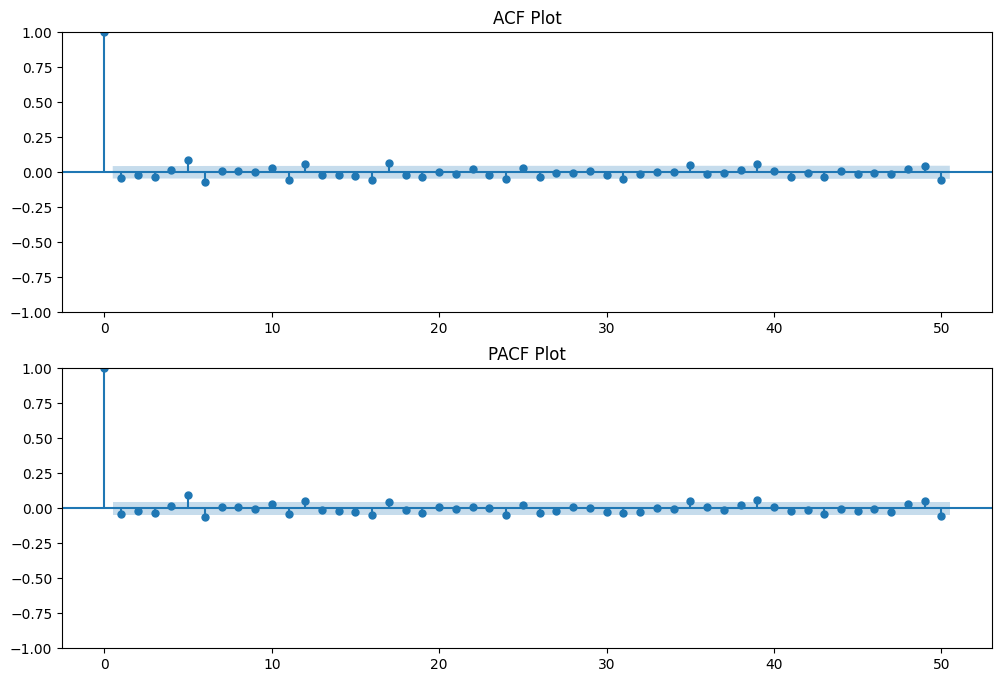

In [15]:
# Plot ACF and PACF for differenced data

plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(211)
plot_acf(y.diff(periods=1).dropna(), ax=plt.gca(), lags=50)
plt.title('ACF Plot')


# PACF plot
plt.subplot(212)
plot_pacf(y.diff(periods=1).dropna(), ax=plt.gca(), lags=50)
plt.title('PACF Plot')
plt.show()

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


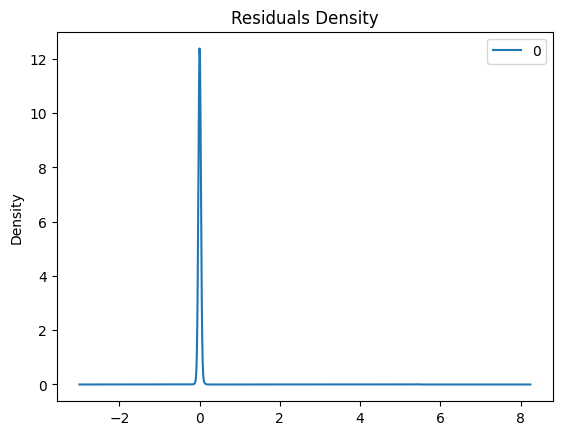

                 0
count  1941.000000
mean      0.003657
std       0.124842
min      -0.185844
25%      -0.008641
50%       0.000425
75%       0.010087
max       5.433920


In [16]:
from statsmodels.tsa.arima.model import ARIMA


# fit model
# model = ARIMA(y, order=(5, 1, 0))  # p, d, q
model = ARIMA(y, order=(5, 1, 0))
model_fit = model.fit()

#print(model_fit.summary())

import pandas as pd
import matplotlib.pyplot as plt

# Residual density refers to the distribution of residuals from a statistical model. 
# Residuals are the differences between the observed values and the values predicted by the model.

# Purpose: By examining the residual density, you can assess whether residuals are normally distributed 
# and identify any patterns or anomalies that suggest problems with the model.

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# residuals.plot(kind='kde')
# print(residuals.describe())

# Plot residuals density
residuals.plot(kind='kde')
plt.title('Residuals Density')
plt.show()

# Print residuals description
print(residuals.describe())


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


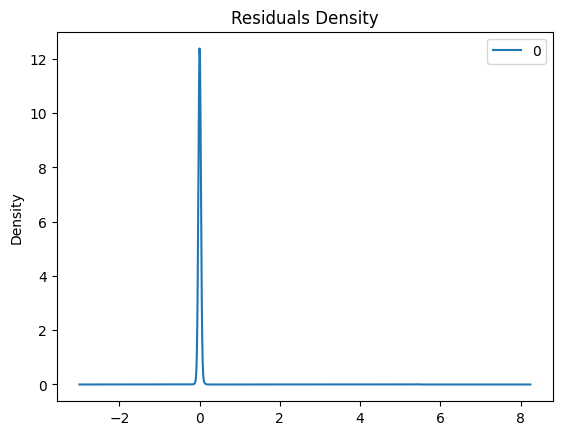

                 0
count  1941.000000
mean      0.003657
std       0.124842
min      -0.185844
25%      -0.008641
50%       0.000425
75%       0.010087
max       5.433920


In [17]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(1, 1, 1))
model_fit = model.fit()

#print(model_fit.summary())

import pandas as pd
import matplotlib.pyplot as plt

# Plot residuals density
residuals.plot(kind='kde')
plt.title('Residuals Density')
plt.show()

# Print residuals description
print(residuals.describe())


In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1941
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4879.099
Date:                Tue, 12 Nov 2024   AIC                          -9752.198
Time:                        23:19:48   BIC                          -9735.487
Sample:                             0   HQIC                         -9746.052
                               - 1941                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7126      0.207      3.444      0.001       0.307       1.118
ma.L1         -0.7349      0.196     -3.743      0.000      -1.120      -0.350
sigma2         0.0004    5.3e-06     72.148      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):             11100.43
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model.endog

array([[5.43392048],
       [5.44359762],
       [5.43054106],
       ...,
       [7.17192559],
       [7.15359918],
       [7.13795387]])

# 4 . Data Splitting and Model Fitting

Spliting the data
we split the normalized data into training and testing sets :

70% for training,
30% for testing.

predicted=6.557871, actual=6.561314
predicted=6.563718, actual=6.556636
predicted=6.557335, actual=6.579390
predicted=6.577025, actual=6.578487
predicted=6.577211, actual=6.587481
predicted=6.587031, actual=6.609349
predicted=6.608205, actual=6.627644
predicted=6.628466, actual=6.645741
predicted=6.644131, actual=6.633187
predicted=6.634335, actual=6.624331
predicted=6.627174, actual=6.623268
predicted=6.626109, actual=6.621672
predicted=6.623586, actual=6.648985
predicted=6.646335, actual=6.660127
predicted=6.658184, actual=6.663260
predicted=6.662032, actual=6.666957
predicted=6.666853, actual=6.684674
predicted=6.686811, actual=6.685736
predicted=6.686460, actual=6.679976
predicted=6.680152, actual=6.685237
predicted=6.685864, actual=6.702697
predicted=6.703830, actual=6.707596
predicted=6.706874, actual=6.713442
predicted=6.712161, actual=6.706557
predicted=6.707547, actual=6.715141
predicted=6.716671, actual=6.709609
predicted=6.710496, actual=6.731257
predicted=6.730639, actual=6

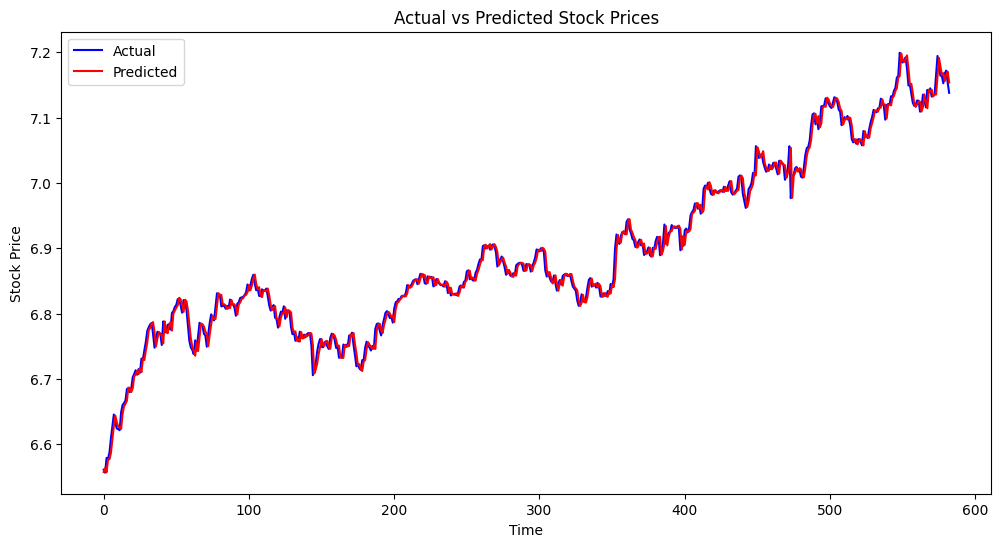

In [20]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Ignore specific warnings
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

# Example data setup (ensure y is defined and contains your data)
x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]

history = list(train)  # Use list() to ensure history is a list
predictions = []

# # Use test samples
num_predictions = len(test)
cnt = 0

for t in range(len(test)):
    if cnt == num_predictions:
        break
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()  # No disp argument
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.6f}, actual={obs:.6f}')
    cnt += 1

# Ensure predictions and test have the same length
if len(predictions) != num_predictions:
    raise ValueError(f"Predictions length ({len(predictions)}) does not match expected number ({num_predictions})")

# Slice the test set to match the length of predictions
test_slice = test[:num_predictions]

# Calculate error
error = mean_squared_error(test_slice, predictions)
print(f'Test RMSE: {np.sqrt(error):.3f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_slice, label='Actual', color='blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
# Calculate metrics
mae = mean_absolute_error(test_slice, predictions)
mse = mean_squared_error(test_slice, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_slice - predictions) / test_slice)) * 100
r2 = r2_score(test_slice, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2:.3f}')

Mean Absolute Error (MAE): 0.009
Mean Squared Error (MSE): 0.000
Root Mean Squared Error (RMSE): 0.012
Mean Absolute Percentage Error (MAPE): 0.13%
R-squared (R²): 0.992


In [24]:
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import matplotlib.pyplot as plt

# x = y.values
# train_size = int(len(x) * 0.7)
# train, test = x[0:train_size], x[train_size:]
# history = [x for x in train]
# predictions = []

# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()  # No disp argument
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, actual=%f' % (yhat, obs))

# error = mean_squared_error(test, predictions)
# print('Test RMSE: %.3f' % np.sqrt(error))

# plt.plot(test, label='Actual')
# plt.plot(predictions, color='red', label='Predicted')
# plt.legend()
# plt.show()


# 5. Making the predictions 

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Fit the ARIMA model on the log-transformed data
model = ARIMA(x_log, order=(5,1,0))  # p, d, q
model_fit = model.fit()

# Forecast the next value in the log-transformed scale
forecast_log = model_fit.forecast(steps=1) # next day
forecast_log_value = forecast_log[0]

# Reverse the logarithmic transformation to get the actual price
forecast_value = np.exp(forecast_log_value)

# Get tomorrow's date
today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow_date_str = tomorrow.strftime('%Y-%m-%d')  # Format date as YYYY-MM-DD

print(f'The predicted stock price for {tomorrow_date_str} is: {forecast_value:.2f}')


The predicted stock price for 2024-11-13 is: 1259.02


                        Date  Forecasted Price
0 2024-11-13 23:24:40.310977       1259.016302
1 2024-11-14 23:24:40.310977       1262.000787
2 2024-11-15 23:24:40.310977       1262.502536
3 2024-11-16 23:24:40.310977       1259.828782
4 2024-11-17 23:24:40.310977       1257.998996
5 2024-11-18 23:24:40.310977       1258.190432
6 2024-11-19 23:24:40.310977       1258.589169
7 2024-11-20 23:24:40.310977       1258.615074
8 2024-11-21 23:24:40.310977       1258.311122
9 2024-11-22 23:24:40.310977       1258.143994


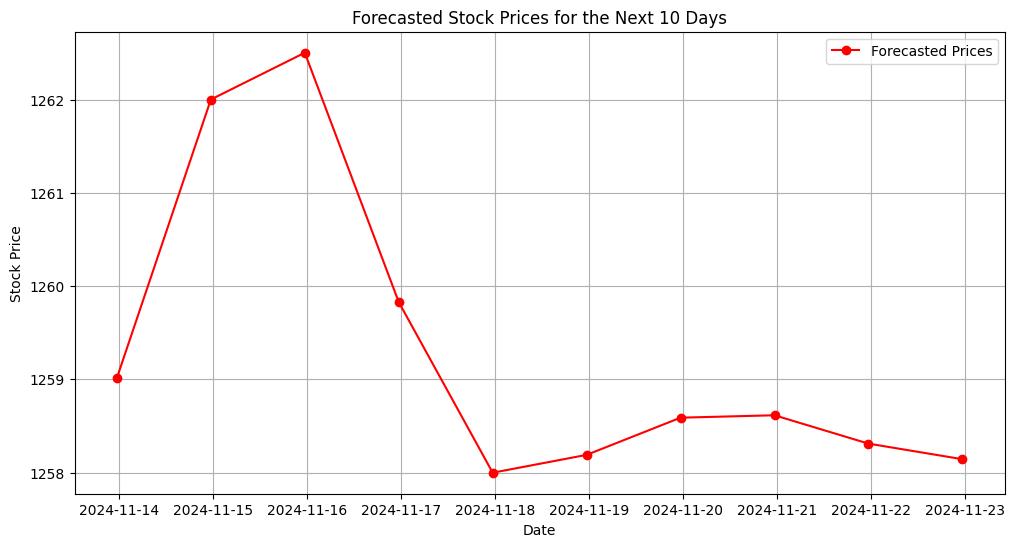

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Fit the ARIMA model on the log-transformed data
model = ARIMA(x_log, order=(5,1,0))  # p, d, q
model_fit = model.fit()

# Forecast the next 10 days in the log-transformed scale
forecast_log = model_fit.forecast(steps=10)
forecast_log_values = forecast_log

# Reverse the logarithmic transformation to get the actual prices
forecast_values = np.exp(forecast_log_values)

# Generate dates for the next 10 days
last_date = pd.to_datetime('today')  # Adjust if you have a specific end date
dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10, freq='D')

# Create a DataFrame to display results
forecast_df = pd.DataFrame({
    'Date': dates,
    'Forecasted Price': forecast_values
})

print(forecast_df)

# Optional: Plot the forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, forecast_values, marker='o', linestyle='-', color='red', label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted Stock Prices for the Next 10 Days')
plt.legend()
plt.grid()
plt.show()


In [41]:


# # Example data setup (ensure y is defined and contains your time series data)
# x = y.values  # y is your data series
# train_size = int(len(x) * 0.6)  # 60% for training
# validation_size = int(len(x) * 0.2)  # 20% for validation

# # Split the data into training, validation, and testing
# train = x[:train_size]
# validation = x[train_size:train_size + validation_size]
# test = x[train_size + validation_size:]

# history = list(train)  # Use list() to ensure history is a list
# validation_predictions = []
# test_predictions = []

# # 1. Validation predictions
# for t in range(len(validation)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     validation_predictions.append(yhat)
#     obs = validation[t]
#     history.append(obs)
#     print(f'Validation - predicted={yhat:.6f}, actual={obs:.6f}')

# # 2. Test predictions
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     test_predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print(f'Test - predicted={yhat:.6f}, actual={obs:.6f}')

# # Calculate RMSE for validation and test sets
# validation_error = mean_squared_error(validation, validation_predictions)
# test_error = mean_squared_error(test, test_predictions)

# print(f'Validation RMSE: {np.sqrt(validation_error):.3f}')
# print(f'Test RMSE: {np.sqrt(test_error):.3f}')

# # Plot the results
# plt.figure(figsize=(14, 7))

# # Plot training data
# plt.plot(range(len(train)), train, label='Training Data', color='green')

# # Plot validation predictions and actual validation data
# plt.plot(range(len(train), len(train) + len(validation)), validation, label='Validation Data', color='blue')
# plt.plot(range(len(train), len(train) + len(validation)), validation_predictions, label='Validation Predictions', linestyle='--', color='orange')

# # Plot test predictions and actual test data
# plt.plot(range(len(train) + len(validation), len(x)), test, label='Test Data', color='blue')
# plt.plot(range(len(train) + len(validation), len(x)), test_predictions, label='Test Predictions', linestyle='--', color='red')

# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.title('Training, Validation, and Test Data vs Predictions')
# plt.legend()
# plt.show()


2. SARIMA

predicted=6.557796, actual=6.561314
predicted=6.562655, actual=6.556636
predicted=6.555229, actual=6.579390
predicted=6.579116, actual=6.578487
predicted=6.576467, actual=6.587481
predicted=6.588783, actual=6.609349
predicted=6.606324, actual=6.627644
predicted=6.632875, actual=6.645741
predicted=6.650348, actual=6.633187
predicted=6.636709, actual=6.624331
predicted=6.626362, actual=6.623268
predicted=6.624828, actual=6.621672
predicted=6.623709, actual=6.648985
predicted=6.645333, actual=6.660127
predicted=6.658398, actual=6.663260
predicted=6.663418, actual=6.666957
predicted=6.666843, actual=6.684674
predicted=6.689314, actual=6.685736
predicted=6.686605, actual=6.679976
predicted=6.684837, actual=6.685237
Test RMSE: 0.013


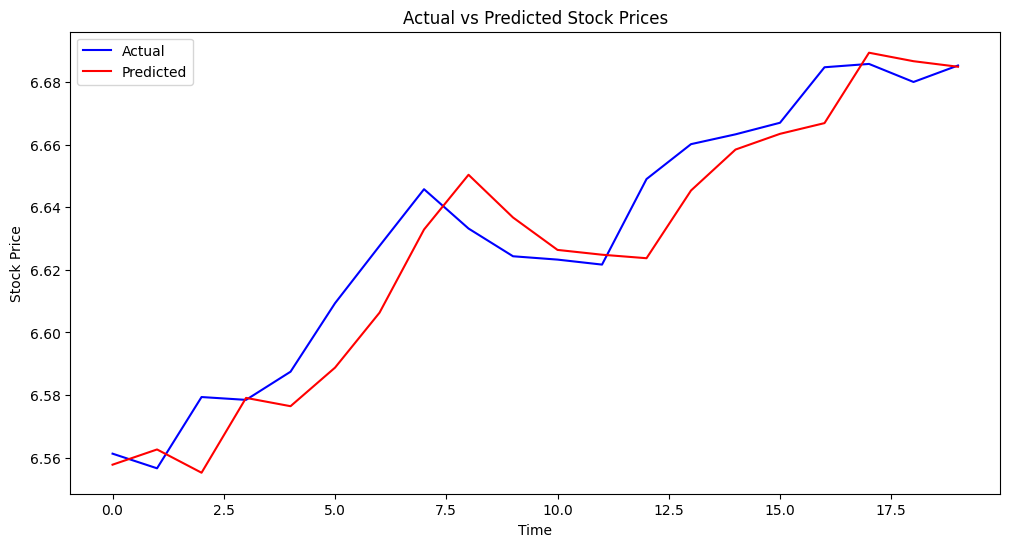

In [28]:
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]

history = list(train)  # Use list() to ensure history is a list
predictions = []

# Define SARIMA parameters
# Adjust the (p, d, q) and (P, D, Q, s) parameters based on your data
seasonal_period = 12  # Example: monthly data with yearly seasonality
num_predictions = 20
cnt = 0

for t in range(len(test)):
    if cnt == num_predictions:
        break
    model = SARIMAX(history, order=(5,1,0), seasonal_order=(1,1,1,seasonal_period))
    model_fit = model.fit(disp=False)  # No disp argument
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.6f}, actual={obs:.6f}')
    cnt += 1

# Ensure predictions and test have the same length
if len(predictions) != num_predictions:
    raise ValueError(f"Predictions length ({len(predictions)}) does not match expected number ({num_predictions})")

# Slice the test set to match the length of predictions
test_slice = test[:num_predictions]

# Calculate error
error = mean_squared_error(test_slice, predictions)
print(f'Test RMSE: {np.sqrt(error):.3f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_slice, label='Actual', color='blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [29]:
# Calculate metrics
mae = mean_absolute_error(test_slice, predictions)
mse = mean_squared_error(test_slice, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_slice - predictions) / test_slice)) * 100
r2 = r2_score(test_slice, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2:.3f}')

Mean Absolute Error (MAE): 0.011
Mean Squared Error (MSE): 0.000
Root Mean Squared Error (RMSE): 0.013
Mean Absolute Percentage Error (MAPE): 0.16%
R-squared (R²): 0.894


In [30]:
model = SARIMAX(x_log, order=(5,1,0), seasonal_order=(1,1,1,12))  # Example parameters
model_fit = model.fit(disp=False)

# Forecast the next value in the log-transformed scale
forecast_log = model_fit.forecast(steps=1) # next day
forecast_log_value = forecast_log[0]

# Reverse the logarithmic transformation to get the actual price
forecast_value = np.exp(forecast_log_value)

# Get tomorrow's date
today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow_date_str = tomorrow.strftime('%Y-%m-%d')  # Format date as YYYY-MM-DD

print(f'The predicted stock price for {tomorrow_date_str} is: {forecast_value:.2f}')

The predicted stock price for 2024-11-13 is: 1263.10


         Date  Forecasted Price
0  2024-11-13       1263.104667
1  2024-11-14       1271.346446
2  2024-11-15       1275.175054
3  2024-11-16       1273.970438
4  2024-11-17       1270.530147
5  2024-11-18       1269.978358
6  2024-11-19       1270.509509
7  2024-11-20       1269.782032
8  2024-11-21       1272.412588
9  2024-11-22       1272.248092


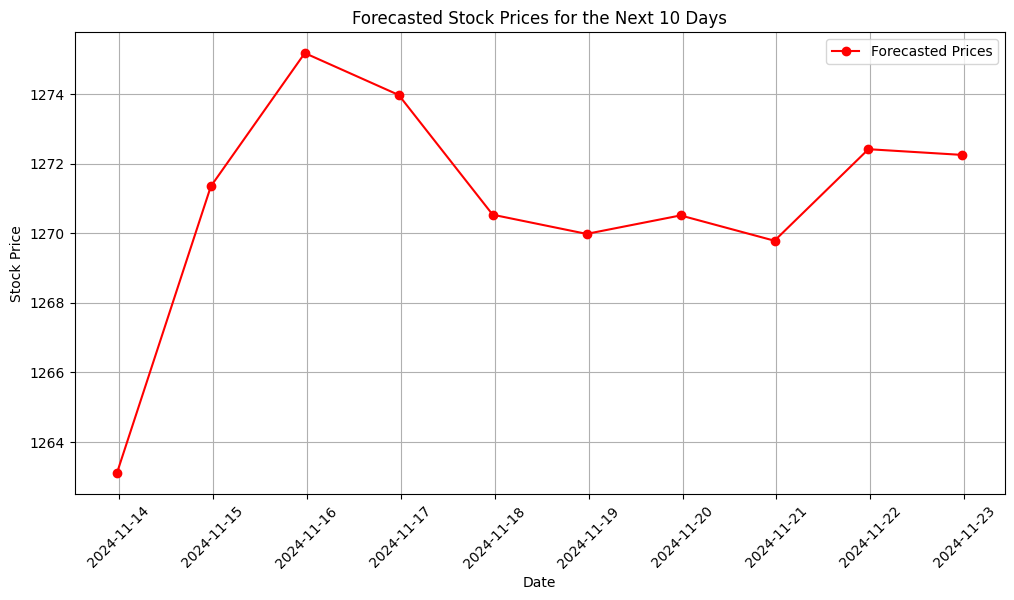

In [31]:
# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Define the SARIMA model
# Example parameters; adjust these based on your data and seasonal period
model = SARIMAX(x_log, order=(5,1,0), seasonal_order=(1,1,1,12))  # Adjust parameters as needed
model_fit = model.fit(disp=False)

# Forecast the next 10 days in the log-transformed scale
forecast_log = model_fit.forecast(steps=10)
forecast_log_values = forecast_log

# Reverse the logarithmic transformation to get the actual prices
forecast_values = np.exp(forecast_log_values)

# Generate dates for the next 10 days
today = datetime.now()
dates = [today + timedelta(days=i+1) for i in range(10)] 
dates_str = [date.strftime('%Y-%m-%d') for date in dates]

# Create a DataFrame to display results
forecast_df = pd.DataFrame({
    'Date': dates_str,
    'Forecasted Price': forecast_values
})

print(forecast_df)

# Optional: Plot the forecasted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, forecast_values, marker='o', linestyle='-', color='red', label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted Stock Prices for the Next 10 Days')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA

# # Assume y is your log-transformed time series data and already loaded
# x_log = y.values
# train_size = int(len(x_log) * 0.7)
# train, test = x_log[0:train_size], x_log[train_size:]
# test_actual = np.exp(test)  # Convert test data back to original scale
# history = [x for x in train]
# predictions = []

# # Forecasting the test period
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))  # p, d, q
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat_log = output[0]
#     yhat = np.exp(yhat_log)  # Convert forecasted log value back to original scale
#     predictions.append(yhat)
#     obs = np.exp(test[t])  # Ensure actual test values are in original scale
#     history.append(test[t])
#     # print('predicted=%f, actual=%f' % (yhat, obs))

# # Convert predictions to a numpy array for easy plotting
# predictions = np.array(predictions)

# # Plot actual vs predicted prices
# plt.figure(figsize=(12, 6))
# plt.plot(test_actual, label='Actual Prices', color='blue')
# plt.plot(predictions, color='red', label='Predicted Prices')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.title('Actual vs Predicted Stock Prices')
# plt.legend()
# plt.show()
